# Advanced Lane Lines
----

----
In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  

---

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
import random

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
from scipy.stats import linregress

%matplotlib inline

----

## Helper Classes

Helper classes to receive characteristics for each line

In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
print('Class line OK')

Class line OK


---

## Helper Functions

Below are some helper functions. Some of them are based on the first line lanes 
:)

### Color Functions

In [3]:
#color functions
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def hls_color(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def binary_s_channel(img, thresh=(40,255)):
    S = img[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def binary_s_channel2(img, thresh=(40,255)):    
    S = img[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 255

    value = np.zeros_like(img)
    value[:,:,2] = binary

    return value

def sobel(img, sobel_kernel=3, dir_thresh=(0, np.pi/2), mag_thresh=(0, 255), abs_thresh=(0,255)):
    #rgb = cv2.cvtColor(img, cv2.COLOR_HLS2RGB)
    gray = grayscale(img)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    #abs sobel
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    scaledx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaledy = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    #direction sobel
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    arctan = np.arctan2(abs_sobely, abs_sobelx)
    
    #gradmag sobel
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    #combined direction sobel with gradmag sobel
    sxbinary = np.zeros_like(arctan)
    sxbinary[(arctan >= dir_thresh[0]) & (arctan <= dir_thresh[1]) & 
             (gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1]) &
             (scaledx >= abs_thresh[0]) & (scaledx <= abs_thresh[1])
            ] = 1
    #(scaledy >= abs_thresh[0]) & (scaledy <= abs_thresh[1])
    
    return sxbinary

print('Color functions OK')

Color functions OK


### Camera Calibration Functions

In [4]:
#camera calibration functions
CONST_CORNERS_HORIZ = 9
CONST_CORNERS_VERT = 6

def calibrate_camera(gray_image, objpoints, imgpoints):
    return cv2.calibrateCamera(objpoints, imgpoints, gray_image.shape[::-1], None, None)

def undistort(chess_image, gray_image, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(gray_image, objpoints, imgpoints)
    return cv2.undistort(chess_image, mtx, dist, None, mtx)

def chessboard(img, corners=(CONST_CORNERS_HORIZ,CONST_CORNERS_VERT)):
    objpoints = []
    imgpoints = []
    objp = np.zeros((corners[0]*corners[1], 3), np.float32)
    objp[:,:2] = np.mgrid[0:corners[0], 0:corners[1]].T.reshape(-1,2)

    #find chessboard corners
    gray = grayscale(img)
    ret, chess_corners = cv2.findChessboardCorners(gray, (corners[0], corners[1]), None)

    #if the chessboard was found
    if ret == True:
        imgpoints.append(chess_corners)
        objpoints.append(objp)
        chess_image = cv2.drawChessboardCorners(img, (corners[0], corners[1]), chess_corners, ret)
    else:
        chess_image = None
    
    return ret, chess_image, objpoints, imgpoints

def calibrate_chess(img):
    corners = [CONST_CORNERS_HORIZ, CONST_CORNERS_VERT]
    ret, chess_image, objpoints, imgpoints = chessboard(img)

    #Different number of corners (try other pattern)!
    if ret == False:
        corners = [9, 5]
        ret, chess_image, objpoints, imgpoints = chessboard(img, corners)
    if ret == False:
        corners = [8, 6]
        ret, chess_image, objpoints, imgpoints = chessboard(img, corners)

    #undistort image
    if ret == True:
        gray_img = grayscale(img)
        undist_img = undistort(chess_image, gray_img, objpoints, imgpoints)
        ret = True
    else:
        ret = False
        undist_img = None
        corners = None
        
    return ret, undist_img, corners

def warped(img, calibrate=True, undist_img=None, corners=None):
    if calibrate == True:
        ret, undist_img, corners = calibrate_chess(img.copy())
    else:
        ret = True
    
    if ret == True:
        nx = corners[0]
        ny = corners[1]
        gray_img = grayscale(img)
        ret, chess_corners = cv2.findChessboardCorners(gray_img, (nx,ny), None)

        if ret == True:
            offset = 100 # offset for dst points
            img_size = (gray_img.shape[1], gray_img.shape[0])
            src = np.float32([chess_corners[0], chess_corners[nx-1], chess_corners[-1], chess_corners[-nx]])
            dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                         [img_size[0]-offset, img_size[1]-offset], 
                                         [offset, img_size[1]-offset]])
            M = cv2.getPerspectiveTransform(src, dst)
            warp_img = cv2.warpPerspective(undist_img, M, img_size)
        else:
            warp_img = None
    else:
        warp_img = None
        
    return ret, warp_img

print('Camera calibration functions OK')

Camera calibration functions OK


### Canny, Gaussian Blur, and Hough Transform Functions

In [5]:
#canny, gaussian blur, and hough transform
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def draw_lines(img, lines, color=[255,0,0], thickness=10):
    left_line = []
    right_line = []
    middle_x = img.shape[1] / 2
    
    '''
    Calculate slope of points and create the lines
      - Reject points on the left side of the pictures if the slope is negative
      - Reject points on the right side of the pictures if the slope is positive
    '''
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope > 0: #right
                #reject entry if slope is positive and (x1 or x2) < (middle of image)
                if x1 > middle_x and x2 > middle_x: 
                    right_line.append([x1,y1]) 
                    right_line.append([x2,y2])
            elif slope < 0: #left
                #reject entry if slope is negative and (x1 or x2) > (middle of image)
                if x1 < middle_x and x1 < middle_x:
                    left_line.append([x1,y1]) 
                    left_line.append([x2,y2])
    
    #plot left line
    ldata = np.array(left_line)
    if len(ldata) > 0:
        lfit = np.polyfit(ldata[:,0], ldata[:,1] , 1)
        l1z = np.poly1d(lfit)

        lx1 = CONST_X_LEFT_BOTTOM
        lx2 = CONST_X_LEFT_TOP
        cv2.line(img, (lx1, int(l1z(lx1))), (lx2, int(l1z(lx2))), color, thickness, 4)
    
    #plot right line
    rdata = np.array(right_line)
    if len(rdata) > 0:
        rfit = np.polyfit(rdata[:,0], rdata[:,1] ,1)
        r1z = np.poly1d(rfit)

        rx1 = img.shape[1] - CONST_X_RIGHT_BOTTOM
        rx2 = img.shape[1] - CONST_X_LEFT_TOP
        cv2.line(img, (rx1, int(r1z(rx1))), (rx2, int(r1z(rx2))), color, thickness, 4)

def hough_lines(base_img, canny_img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(canny_img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros((canny_img.shape[0], canny_img.shape[1], 3), dtype=np.uint8)
    draw_lines(base_img, lines)
    return base_img

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.4, β=0.6, λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

print('Hough functions OK')

Hough functions OK


### Process Image (Hough) Function

In [6]:
#process image (hough)
def process_image(image):
    gray = grayscale(image)
    base_image = np.copy(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold) 

    # This time we are defining a four sided polygon to mask
    vertices = vertices_to_crop(image)
    masked_edges = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10 # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 15 # minimum number of pixels making up a line
    max_line_gap = 10 # maximum gap in pixels between connectable line segments    
    
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    
    hough_image = hough_lines(image, masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
        
    # Draw the lines on the edge image
    w_image = weighted_img(hough_image, base_image)
    
    return w_image

print('Process images function OK')

Process images function OK


### Histogram Functions

In [7]:
CONST_HISTOGRAM_MARGIN = 10

def fit_histogram(img):
    # Assuming you have created a warped binary image called "img"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 20
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = CONST_HISTOGRAM_MARGIN
    # Set minimum number of pixels found to recenter window
    minpix = 30
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return out_img, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy

def fit_continuous(img):
    hist_img, left_fit, right_fit, left_lane, right_lane, nonzerox, nonzeroy = fit_histogram(img)
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = CONST_HISTOGRAM_MARGIN
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy

def fit_lane(img):
    hist_img, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = fit_histogram(img)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return ploty, left_fitx, right_fitx

def plot_histogram(img):
    hist_img, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = fit_histogram(img)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    hist_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    hist_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(hist_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return ploty, left_fitx, right_fitx
    
def plot_continuous(img):
    #fit plotting
    left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = fit_continuous(img.copy())

    # Generate x and y values for plotting
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-CONST_HISTOGRAM_MARGIN, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+CONST_HISTOGRAM_MARGIN, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-CONST_HISTOGRAM_MARGIN, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+CONST_HISTOGRAM_MARGIN, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

print('Histogram functions OK')

Histogram functions OK


### Calculate Curvature and Relative Positions Functions

In [8]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/1280 # meters per pixel in x dimension

def curvature(left_fitx, right_fitx, ploty):
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad

def relative_position(mean_fitx):
    return ((1280/2)-mean_fitx)*xm_per_pix

def write_text(img, curve_rad, position):
    #if radius > 2000m (arbitrary value), we have a straight
    if curve_rad <= 2000.: 
        txt_curve = "Left Radius:" + str('{0:.2f}'.format(curve_rad)) + "m"
    else:
        txt_curve = "Left Radius: -"
        
    txt_pos = "Relative Pos: " + str('{0:.2f}'.format(position)) + "m"
    
    draw_img = cv2.putText(img=np.copy(img)
                               , text=(txt_curve + " | " + txt_pos)
                               , org=(10,50)
                               , fontFace=2
                               , fontScale=1.5
                               , color=(255,255,255)
                               , thickness=2
    )
    return draw_img

print('Calculate curvature function OK')

Calculate curvature function OK


### Region of Interests (ROI) Functions

In [9]:
#region of interests
CONST_X_LEFT_TOP = 540
CONST_X_LEFT_BOTTOM = 200
CONST_X_RIGHT_BOTTOM = 1200
CONST_Y_TOP = 450
CONST_Y_BOTTOM = 680

def region_of_interest(img, vertices):
    mask = np.zeros_like(img) #defining a blank mask to start with
    
    if len(img.shape) > 2: #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color) #filling pixels inside the polygon with the fill color    
    return cv2.bitwise_and(img, mask)

def vertices_to_crop(img):
    imshape = img.shape
    left_top = (CONST_X_LEFT_TOP,CONST_Y_TOP)
    left_bot = (CONST_X_LEFT_BOTTOM, CONST_Y_BOTTOM)
    right_top = ((imshape[1]-CONST_X_LEFT_TOP), CONST_Y_TOP)
    right_bot = (CONST_X_RIGHT_BOTTOM, CONST_Y_BOTTOM)
    vertices = np.array([[left_bot, left_top, right_top, right_bot]], dtype=np.int32)
    return vertices

print('Region of Interests functions OK')

Region of Interests functions OK


### Warp Transform Functions

In [10]:
vertices_src = np.float32(
    [[ 120, 720],
     [ 500, 500],
     [ 700, 500],
     [1200, 720]]
)

vertices_dst = np.float32(
    [[ 500, 720],
     [ 500, 0],
     [ 620, 0],
     [ 660, 720]]
)

CONST_VERT_X1 = 500
CONST_VERT_X2 = 690
CONST_VERT_Y1 = 0
CONST_VERT_Y2 = 670

vertices_y_top = 550

def warp_transform(img, inv=False):
    #compute perspective, transform M
    if inv == False:
        M = cv2.getPerspectiveTransform(vertices_src, vertices_dst)
    else:
        M = cv2.getPerspectiveTransform(vertices_dst, vertices_src)

    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))

print('Warp transform functions OK')

Warp transform functions OK


---

## Pipeline

In [11]:
CONST_PIPELINE_S_CHANNEL_THRESH = (100,255)

mtx = []
dist = []

In [44]:
def pipeline(img):
    #undistort image
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    '''
    #convert to HSV color and define region of interest (ROI)
    #hsl_img = hls_color(undist_img) #convert to HSV color
    #vertices = vertices_to_crop(hsl_img) #define region of interests
    #roi_img = region_of_interest(hsl_img, vertices)

    #process s channel and sobel
    #s_img = binary_s_channel(roi_img, CONST_PIPELINE_S_CHANNEL_THRESH)
    #sobel_img = sobel(s_img, sobel_kernel=5, dir_thresh=(0.5, 2), mag_thresh=(50,255), abs_thresh=(50,255))
    '''
    x1 = CONST_VERT_X1
    x2 = CONST_VERT_X2
    y1 = CONST_VERT_Y1
    y2 = CONST_VERT_Y2
    
    #warp original image and s channel image
    warp_orig = warp_transform(undist_img)
    
    #convert to HSL
    #warp_s = binary_s_channel(warp_f, thresh=(100,255))
    warp_s2 = binary_s_channel2(warp_orig, thresh=(75,170)) #120,170
    warp_sobel = sobel(warp_s2, sobel_kernel=5, dir_thresh=(0, 3), mag_thresh=(120,200), abs_thresh=(120,200))
    
    #define region of interest
    warp_f = np.zeros_like(warp_sobel)
    warp_f[y1:y2, x1:x2] = warp_sobel[y1:y2, x1:x2]

    #apply fit continuous in the s channel image
    #left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = fit_continuous(warp_sobel)
    ploty, left_fitx, right_fitx = fit_lane(warp_f)
    
    #draw green area over the warp image ()
    shape_x = warp_orig.shape[0]
    shape_y = warp_orig.shape[1]
    
    green_warp = warp_orig                
    for i in range(1, warp_orig.shape[0]):
        for j in range(int(left_fitx[i]), int(right_fitx[i])):
            if j < 1280 and j > 0:
                green_warp[i,j,0] = 0.
                green_warp[i,j,2] = 0.

    #unwarp image
    green_persp = warp_transform(green_warp,True)

    #merge unwarp image with the original image
    green_persp[0:vertices_y_top, :] = undist_img[0:vertices_y_top, :]
    
    #write curvature and distance to the center
    '''
    ploty = np.linspace(0, green_persp.shape[0]-1, green_persp.shape[0] )
    left_curverad, right_curverad = curvature(left_fitx, right_fitx, ploty)
    pos = relative_position(np.mean(left_fitx)) #use continuous track line, to increase accuracy
    
    final_img = write_text(green_persp, left_curverad, pos) #use continuous track line, to increase accuracy
    '''
    return green_persp

print('Pipeline OK')

Pipeline OK


---

---

## Calibration Images

camera_cal/calibration2.jpg


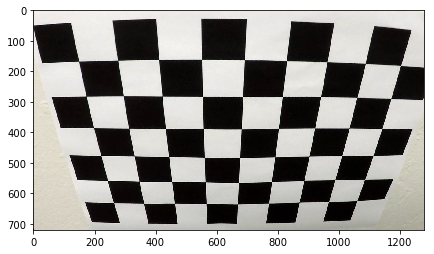

In [13]:
img_index = random.randint(1,20)
img_name = 'camera_cal/calibration' + str(2) + '.jpg' #img_index
print(img_name)

cal_image = mpimg.imread(img_name)
plt.figure(figsize=(7,7))
plt.imshow(cal_image)

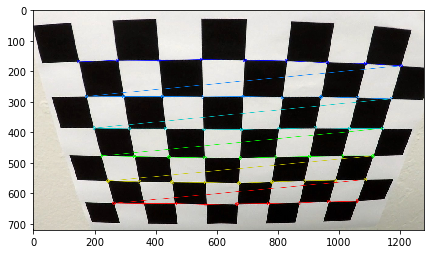

In [14]:
#find chessboard corner
ret, chess_image, objpoints, imgpoints = chessboard(cal_image.copy())

if ret == False:
    print('Different number of corners!')
    ret, chess_image, objpoints, imgpoints = chessboard(cal_image.copy(), [9, 5])

#plot image
if ret == True:
    plt.figure(figsize=(7,7))
    plt.imshow(chess_image)
else:
    print('Corners not found!')

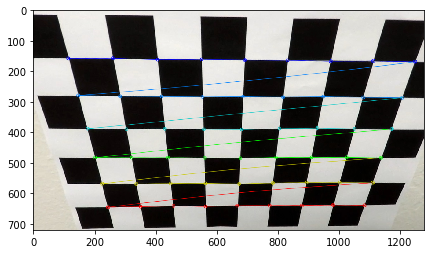

In [15]:
#undistort image
if ret == True:
    gray_img = grayscale(cal_image.copy())
    r, mtx, dist, rvecs, tvecs = calibrate_camera(gray_img, objpoints, imgpoints)
    undist_img = undistort(chess_image, gray_img, objpoints, imgpoints)
        
    #plot image
    plt.figure(figsize=(7,7))
    plt.imshow(undist_img)
else:
    print('Corners not found!')

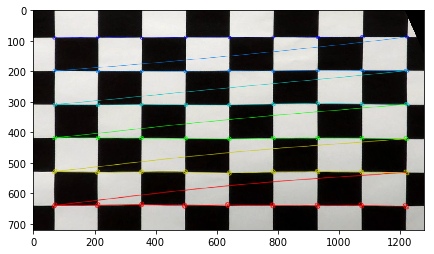

In [16]:
#unwarped images
if ret == True:
    ret, warp_img = warped(cal_image.copy())
        
    #plot image
    if ret == True:
        plt.figure(figsize=(7,7))
        plt.imshow(warp_img)
else:
    print('Corners not found!')

### Camera Calibration Path

In [17]:

CONST_INPUT_CALIBRAT_PATH = "camera_cal/"
CONST_OUTPUT_CALIBRAT_PATH = "output_images/"

img_paths = os.listdir(CONST_INPUT_CALIBRAT_PATH)

#ar_mtx = []
#ar_dist = []

for img_name in img_paths:
    image = mpimg.imread(CONST_INPUT_CALIBRAT_PATH + img_name)
    
    '''
    #find chessboard
    corners = [9,6]
    ret, chess_image, objpoints, imgpoints = chessboard(image)
    if ret == False: #Different number of corners!
        corners = [9,5]
        ret, chess_image, objpoints, imgpoints = chessboard(cal_image.copy(), [9, 5])
    
    #chessboard ok
    if ret == True:
        gray_img = grayscale(image)
        r, mtx, dist, rvecs, tvecs = calibrate_camera(gray_img, objpoints, imgpoints)
        ar_mtx.append(mtx)
        ar_dist.append(dist)
    
        undist_img = undistort(chess_image, gray_img, objpoints, imgpoints)
        ret, warp_img = warped(image, False, undist_img, corners)
    
    #save image
    if ret == True:
        plt.imshow(warp_img)
        plt.savefig(CONST_OUTPUT_CALIBRAT_PATH + img_name)
    ''' 
    ret, warp_img = warped(image)
    print(img_name)
    
#mtx = np.mean(ar_mtx, axis=0)
#dist = np.mean(ar_dist, axis=0)

calibration17.jpg
calibration13.jpg
calibration8.jpg
calibration20.jpg
calibration10.jpg
calibration19.jpg
calibration3.jpg
calibration16.jpg
calibration12.jpg
calibration11.jpg
calibration6.jpg
calibration9.jpg
calibration5.jpg
calibration18.jpg
calibration7.jpg
calibration4.jpg
calibration2.jpg
calibration14.jpg
calibration1.jpg
calibration15.jpg


---

---

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

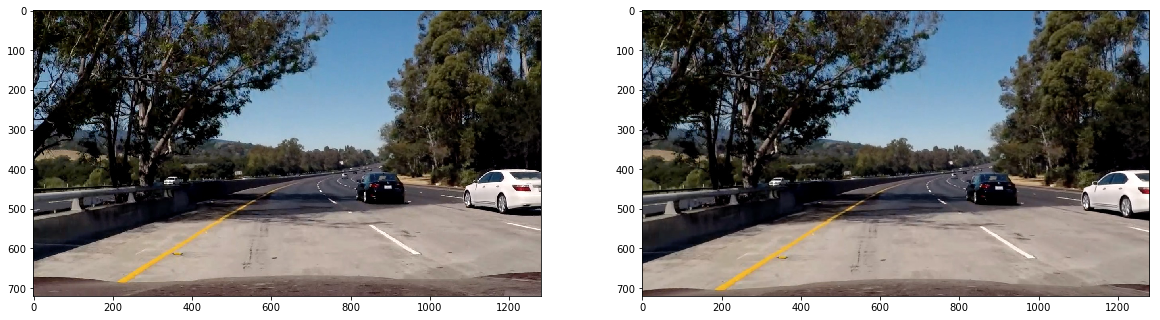

In [18]:
original_img = mpimg.imread('test_images/test5.jpg')

#undistort image
image = cv2.undistort(original_img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.imshow(original_img)
ax2.imshow(image)

In [19]:
#define region of interests (ROI)
vertices = vertices_to_crop(image)
print(vertices)

[[[ 200  680]
  [ 540  450]
  [ 740  450]
  [1200  680]]]


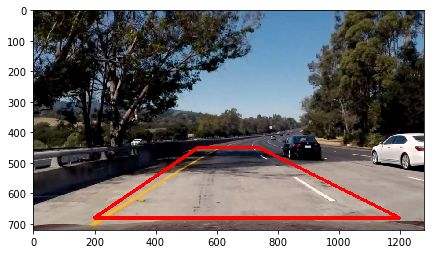

In [20]:
#draw ROI
draw_img = cv2.polylines(image.copy(),[vertices],True,(255,0,0), thickness = 10)
plt.figure(figsize=(7,7))
plt.imshow(draw_img)

In [21]:
#convert to shv color and get region of interests (ROI)
hsv_img = hls_color(image.copy()) #convert to HSV color
vertices = vertices_to_crop(hsv_img) #define region of interests
roi_img = region_of_interest(hsv_img, vertices)

print('ROI OK')

ROI OK


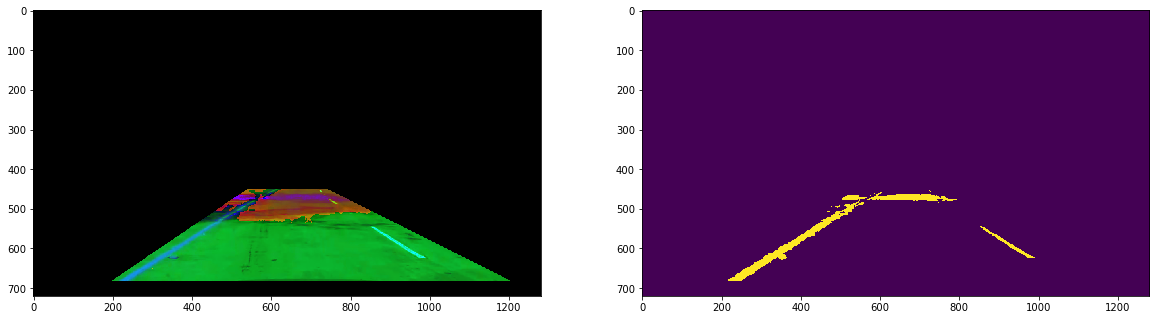

In [22]:
#process s channel
s_img = binary_s_channel(roi_img.copy(), (70,255)) #process s channel
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(roi_img)
ax2.imshow(s_img)

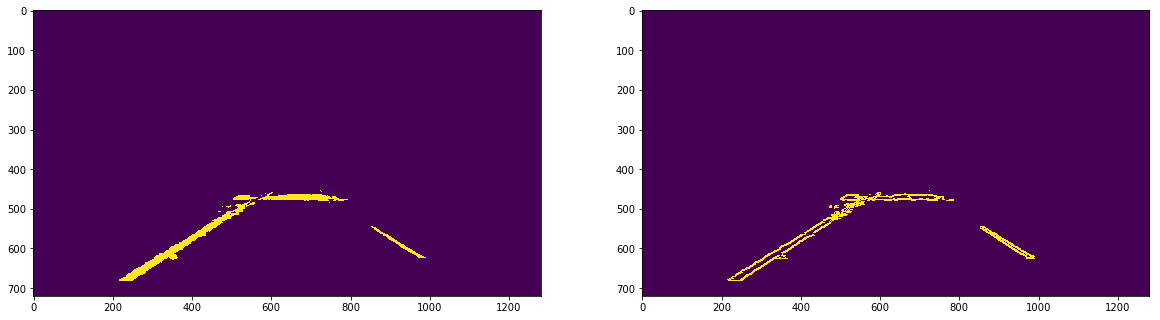

In [23]:
#sobel image
s_img2 = binary_s_channel2(roi_img.copy(), thresh=(100,255))
sobel_img = sobel(s_img2, sobel_kernel=5, dir_thresh=(0.5, 2), mag_thresh=(0,255), abs_thresh=(0,255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(s_img)
ax2.imshow(sobel_img)

### 2D Image transform and analysis

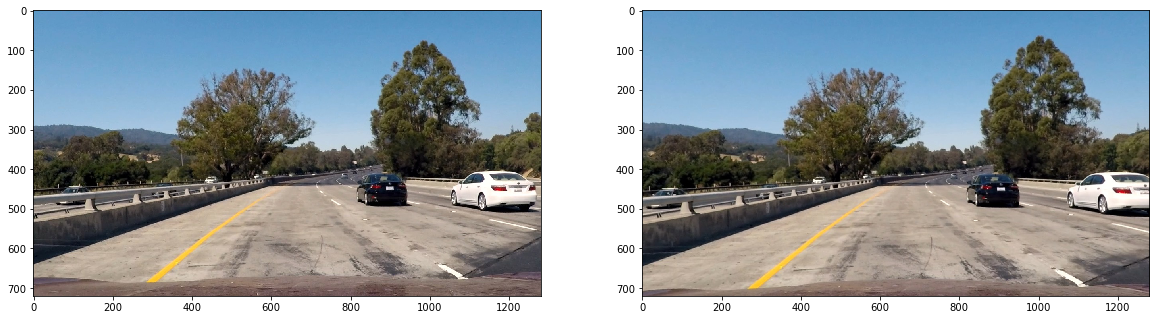

In [24]:
original_img = mpimg.imread('test_images/test1.jpg')

#undistort image
image = cv2.undistort(original_img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.imshow(original_img)
ax2.imshow(image)

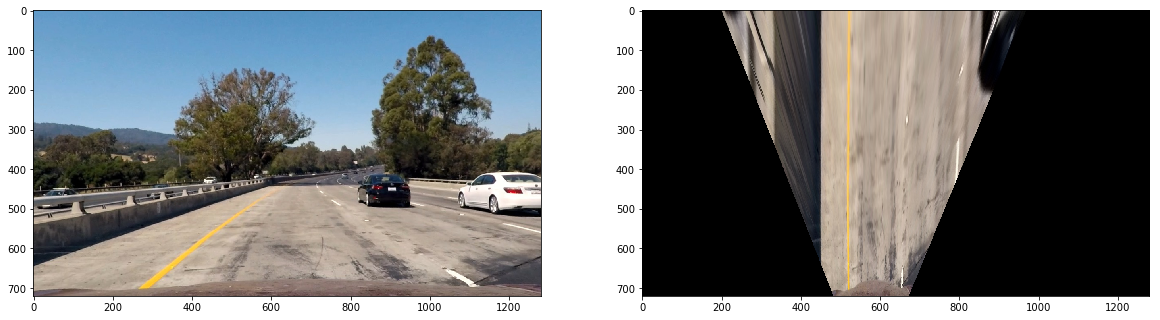

In [25]:
#warp original image
warp_orig = warp_transform(image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image)
ax2.imshow(warp_orig)

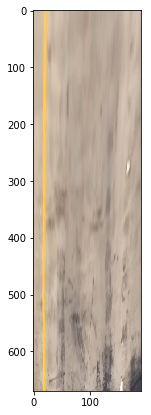

In [26]:
#crop image
warp_crop = warp_orig[CONST_VERT_Y1:CONST_VERT_Y2, CONST_VERT_X1:CONST_VERT_X2]  #new TODO
plt.figure(figsize=(7,7))
plt.imshow(warp_crop)

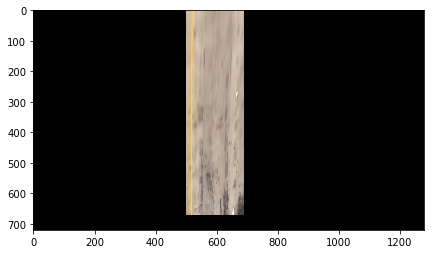

In [27]:
warp_f = np.zeros_like(warp_orig)
warp_f[CONST_VERT_Y1:CONST_VERT_Y2, CONST_VERT_X1:CONST_VERT_X2] = warp_crop
plt.figure(figsize=(7,7))
plt.imshow(warp_f)

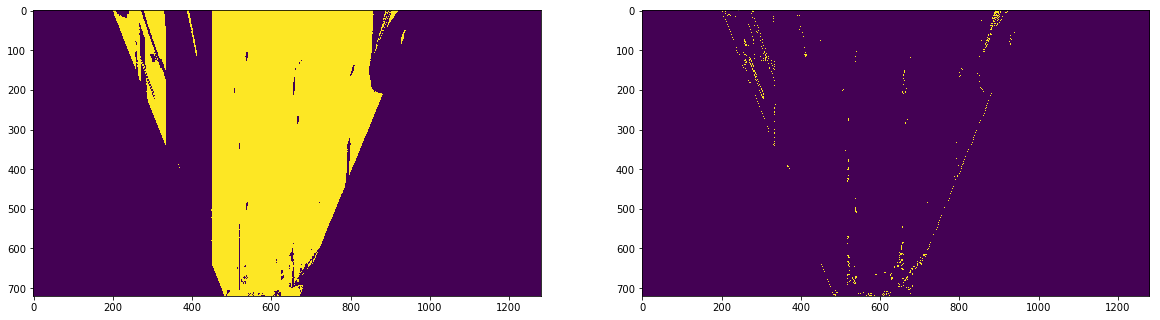

In [28]:
warp_s = binary_s_channel(warp_orig, thresh=(80, 180))
warp_s2 = binary_s_channel2(warp_orig, thresh=(80,180))
warp_sobel = sobel(warp_s2, sobel_kernel=5, dir_thresh=(0, 2), mag_thresh=(100,200), abs_thresh=(100,200))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(warp_s)
ax2.imshow(warp_sobel)

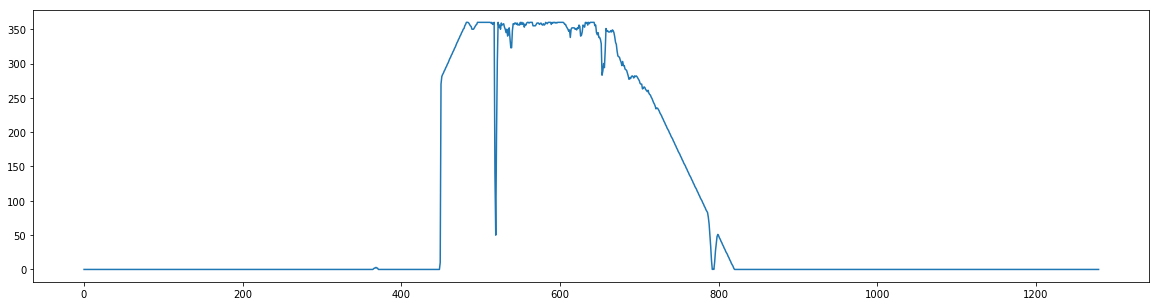

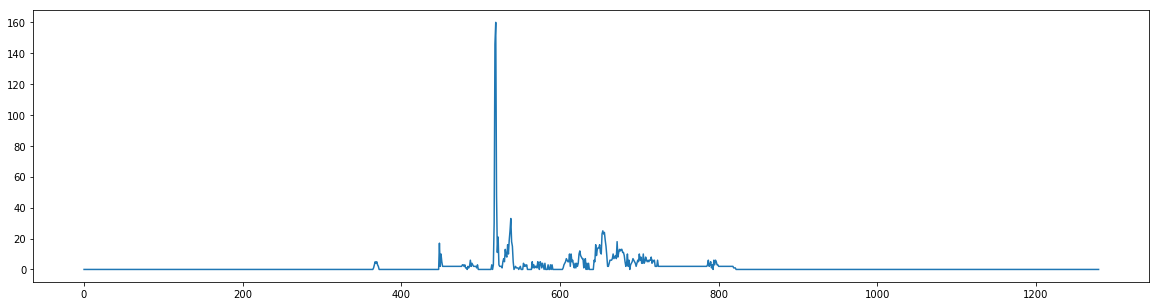

In [29]:
#plot image histogram (3d - s channel)
histogram = np.sum(warp_s[warp_s.shape[0]//2:,:], axis=0)
plt.figure(figsize=(20,5))
plt.plot(histogram)

histogram = np.sum(warp_sobel[warp_sobel.shape[0]//2:,:], axis=0)
plt.figure(figsize=(20,5))
plt.plot(histogram)

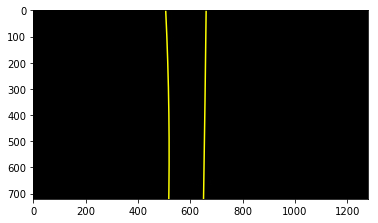

In [30]:
#plot histogram image
warp_f = np.zeros_like(warp_sobel)
warp_f[CONST_VERT_Y1:CONST_VERT_Y2, CONST_VERT_X1:CONST_VERT_X2] = warp_sobel[CONST_VERT_Y1:CONST_VERT_Y2, CONST_VERT_X1:CONST_VERT_X2]
ploty, left_fitx, right_fitx = plot_histogram(warp_f) #sobel

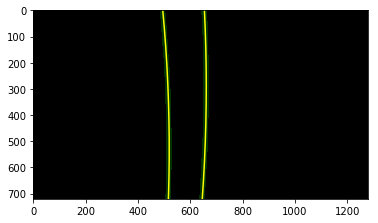

In [31]:
#plot histogram continuous image
plot_continuous(warp_f)

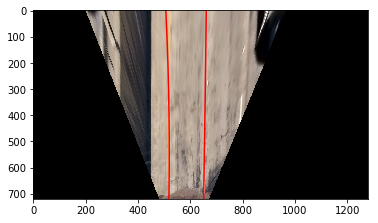

In [32]:
# Generate x and y values for plotting
plt.imshow(warp_orig)
plt.plot(left_fitx, (np.linspace(0, warp_orig.shape[0]-1, warp_orig.shape[0])), color='red')
plt.plot(right_fitx, (np.linspace(0, warp_orig.shape[0]-1, warp_orig.shape[0])), color='red')

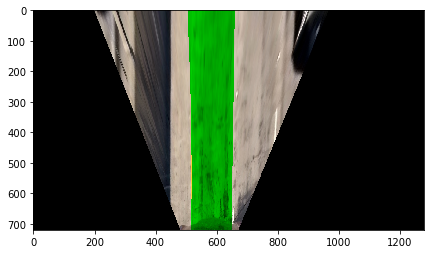

In [33]:
#light camera vision
green_warp = warp_orig.copy()
for i in range(1, warp_orig.shape[0]):
    for j in range(int(left_fitx[i]), int(right_fitx[i])):
        green_warp[i,j,0] = 0.
        green_warp[i,j,2] = 0.

#green_warp = green_warp[:, min_lfitx:max_rightx]
plt.figure(figsize=(7,7))
plt.imshow(green_warp)

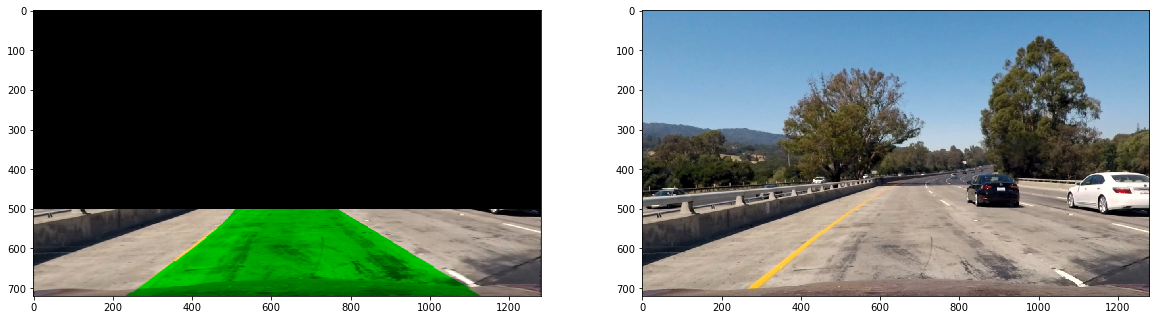

In [34]:
green_persp = warp_transform(green_warp,True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(green_persp)
ax2.imshow(image)

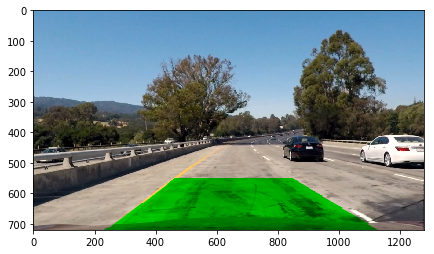

In [35]:
#combine images
green_persp[0:vertices_y_top, :] = image[0:vertices_y_top, :]
plt.figure(figsize=(7,7))
plt.imshow(green_persp)

In [36]:
#print image dimensions
left_curverad, right_curverad = curvature(left_fitx, right_fitx, ploty)
print(left_curverad, right_curverad)

6824.86392647 83885.0999237


---

## Pipeline Test (Image Directory)

test_images/test6.jpg
test_images/straight_lines1.jpg
test_images/test2.jpg
test_images/falreis.jpg
test_images/test5.jpg
test_images/test4.jpg
test_images/straight_lines2.jpg
test_images/test1.jpg
test_images/test3.jpg


"\n#test pipeline\noriginal_image = mpimg.imread('test_images/test2.jpg')\npipe_img = pipeline(original_image)\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))\nax1.imshow(original_image)\nax2.imshow(pipe_img)\n"

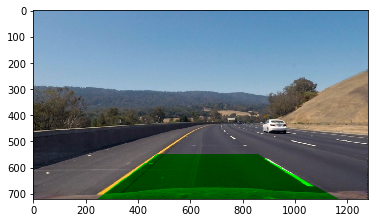

In [45]:
CONST_INPUT_PIPELINE_PATH = "test_images/"
CONST_OUTPUT_PIPELINE_PATH = "output_images/"

img_paths = os.listdir(CONST_INPUT_PIPELINE_PATH)

for img_name in img_paths:
    original_image = mpimg.imread(CONST_INPUT_PIPELINE_PATH + img_name)
    pipe_img = pipeline(original_image)
    
    #save image
    plt.imshow(pipe_img)
    plt.savefig(CONST_OUTPUT_PIPELINE_PATH + img_name)
    print(CONST_INPUT_PIPELINE_PATH + img_name)

'''
#test pipeline
original_image = mpimg.imread('test_images/test2.jpg')
pipe_img = pipeline(original_image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(original_image)
ax2.imshow(pipe_img)
'''

---

---

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

Provided videos: `project_video.mp4`

In [46]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

Let's try the one with the solid white lane on the right first ...

In [47]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

video_output = 'output_project_video.mp4'

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [12:06<00:00,  1.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 15min 34s, sys: 17.1 s, total: 15min 51s
Wall time: 12min 11s


In [48]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Challenge the others videos.
`challenge_video.mp4`
`hard_challenge_video.mp4`